In [6]:
%matplotlib ipympl
import numpy as np
from pathlib import Path
import utils as utils
import harp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import aeon.io.video as video

In [7]:
# Load data

root = Path('/Volumes/harris/hypnose/raw_data/sub-015_id-041/ses-09_date-20250228/behav/2025-02-28T16-51-53')

In [9]:
# Load relevant data streams

behavior_reader = harp.reader.create_reader('device_schemas/behavior.yml', epoch=harp.io.REFERENCE_EPOCH)
olfactometer_reader = harp.reader.create_reader('device_schemas/olfactometer.yml', epoch=harp.io.REFERENCE_EPOCH)
video_reader = utils.Video()
video_data = utils.load_video(video_reader, root/"VideoData")

digital_input_data = utils.load(behavior_reader.DigitalInputState, root/"Behavior")
output_set = utils.load(behavior_reader.OutputSet, root/"Behavior")
output_clear = utils.load(behavior_reader.OutputClear, root/"Behavior")
olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
olfactometer_end_0 = utils.load(olfactometer_reader.EndValveState, root/"Olfactometer0")
analog_data = utils.load(behavior_reader.AnalogData, root/"Behavior")
flow_meter = utils.load(olfactometer_reader.Flowmeter, root/"Olfactometer0")
heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")

# 'other' events
pulse_supply_1 = utils.load(behavior_reader.PulseSupplyPort1, root/"Behavior") # reward A pump end time
pulse_supply_2 = utils.load(behavior_reader.PulseSupplyPort2, root/"Behavior") # reward B pump end time
pulse_enable = utils.load(behavior_reader.OutputPulseEnable, root/"Behavior") # allow for either pump to deliver reward


In [10]:
# Extract relevant events
init_poke = digital_input_data['DIPort0'][digital_input_data['DIPort0'] == True]
r1_poke = digital_input_data['DIPort1'][digital_input_data['DIPort1'] == True]
r2_poke = digital_input_data['DIPort2'][digital_input_data['DIPort2'] == True]

r1_reward = pd.Series(True, index=pulse_supply_1.index, name="PulseSupplyPort1")
r2_reward = pd.Series(True, index=pulse_supply_2.index, name="PulseSupplyPort2")

r1_olf_valve = olfactometer_valves_0['Valve0'][olfactometer_valves_0['Valve0'] == True]
r2_olf_valve = olfactometer_valves_0['Valve1'][olfactometer_valves_0['Valve1'] == True]

In [14]:
# Create individual Series with unique timestamps
def create_unique_series(events, name):
    # Get timestamps and make them unique by adding microsecond offsets if needed
    timestamps = events.index
    if len(timestamps) != len(set(timestamps)):
        # If we have duplicates, handle them by adding microsecond offsets
        unique_timestamps = []
        seen = set()
        for ts in timestamps:
            counter = 0
            ts_modified = ts
            while ts_modified in seen:
                # Add microseconds to make timestamp unique
                counter += 1
                ts_modified = ts + pd.Timedelta(microseconds=counter)
            seen.add(ts_modified)
            unique_timestamps.append(ts_modified)
        timestamps = unique_timestamps
    return pd.Series(True, index=timestamps)

# Create Series with unique timestamps
init_poke_series = create_unique_series(init_poke, 'init_poke')
r1_poke_series = create_unique_series(r1_poke, 'r1_poke')
r2_poke_series = create_unique_series(r2_poke, 'r2_poke')
r1_reward_series = create_unique_series(r1_reward, 'r1_reward')
r2_reward_series = create_unique_series(r2_reward, 'r2_reward')
r1_olf_valve_series = create_unique_series(r1_olf_valve, 'r1_olf_valve')
r2_olf_valve_series = create_unique_series(r2_olf_valve, 'r2_olf_valve')

# For heartbeat, we may need to sample it to reduce duplications
# Taking every Nth value
sampling_rate = 10  # Adjust this as needed
heartbeat_sampled = heartbeat.iloc[::sampling_rate]
heartbeat_series = create_unique_series(heartbeat_sampled, 'heartbeat')

# Create the DataFrame with the unique Series
events_df = pd.DataFrame({
    'init_poke': init_poke_series,
    'r1_poke': r1_poke_series,
    'r2_poke': r2_poke_series,
    'r1_reward': r1_reward_series,
    'r2_reward': r2_reward_series,
    'r1_olf_valve': r1_olf_valve_series,
    'r2_olf_valve': r2_olf_valve_series,
    'heartbeat': heartbeat_series
})

# Reset index to convert timestamps to a column
events_df = events_df.reset_index(names='timestamp')

# Fill NaN values with False (where events didn't occur)
events_df = events_df.fillna(False)

# Sort by timestamp
events_df = events_df.sort_values('timestamp')

# Ask user for start time
# For Jupyter notebooks, we can use a simple input widget
from ipywidgets import widgets
from IPython.display import display

# Find the first heartbeat event
first_heartbeat = events_df[events_df['heartbeat'] == True]['timestamp'].min()

start_time_input = widgets.Text(
    value='2025-02-27 19:20:01.000',
    description='Start Time:',
    style={'description_width': 'initial'}
)

# Display the input widget with info about the reference time
print(f"Reference heartbeat timestamp: {first_heartbeat}")
display(start_time_input)

# Function to apply once the user has entered a start time
def adjust_timestamps(start_time_str):
    try:
        # Parse the input string to a timestamp
        new_start_time = pd.Timestamp(start_time_str)
        
        # Calculate the time delta based on first heartbeat
        first_heartbeat = events_df[events_df['heartbeat'] == True]['timestamp'].min()
        time_delta = new_start_time - first_heartbeat
        
        # Create a new DataFrame with adjusted timestamps
        events_df_adjusted = events_df.copy()
        events_df_adjusted['timestamp'] = events_df['timestamp'] + time_delta
        
        # Keep only the first heartbeat entry and remove all other heartbeat-only entries
        other_columns = [col for col in events_df_adjusted.columns if col not in ['timestamp', 'heartbeat']]
        first_heartbeat_row = events_df_adjusted['timestamp'] == (first_heartbeat + time_delta)
        rows_with_other_events = events_df_adjusted[other_columns].any(axis=1)
        
        # Rows to keep: either the first heartbeat OR any row with other events
        rows_to_keep = first_heartbeat_row | rows_with_other_events
        
        # Filter to keep the desired rows
        events_df_adjusted = events_df_adjusted[rows_to_keep]
        
        return events_df_adjusted
        
    except Exception as e:
        print(f"Error adjusting timestamps: {e}")
        return None

# Button to trigger the adjustment
adjust_button = widgets.Button(description="Adjust Timestamps")

def on_button_click(b):
    global events_df_adjusted
    events_df_adjusted = adjust_timestamps(start_time_input.value)
    print(f"Timestamps adjusted to start at {start_time_input.value}")
    print(f"First event is now at: {events_df_adjusted['timestamp'].min()}")
    print(f"Total events after filtering: {len(events_df_adjusted)}")
    display(events_df_adjusted.head())

adjust_button.on_click(on_button_click)
display(adjust_button)

Reference heartbeat timestamp: 1904-01-01 01:32:15


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_13107/3356136012.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_df = events_df.fillna(False)


Text(value='2025-02-27 19:20:01.000', description='Start Time:', style=TextStyle(description_width='initial'))

Button(description='Adjust Timestamps', style=ButtonStyle())

,timestamp,init_poke,r1_poke,r2_poke,r1_reward,r2_reward,r1_olf_valve,r2_olf_valve,heartbeat
0,2025-02-28 16:53:00.000000,False,False,False,False,False,False,False,True
1,2025-02-28 16:53:06.124800,True,False,False,False,False,False,False,False
2,2025-02-28 16:53:06.157504,False,False,False,False,False,True,False,False
3,2025-02-28 16:53:06.157505,False,False,False,False,False,True,False,False
4,2025-02-28 16:53:06.157506,False,False,False,False,False,True,False,False


,period_start,period_end,r1_accuracy,r1_correct,r1_total,r2_accuracy,r2_correct,r2_total,overall_accuracy
0,2025-02-28 16:53:00,2025-03-01 04:53:00,80.000000,80,100,14.285714,10,70,52.941176
1,2025-03-01 04:53:00,2025-03-01 16:53:00,66.666667,80,120,21.428571,30,140,42.307692
2,2025-03-01 16:53:00,2025-03-02 04:53:00,97.260274,710,730,6.896552,40,580,57.251908
3,2025-03-02 04:53:00,2025-03-02 16:53:00,96.666667,290,300,0.000000,0,300,48.333333
4,2025-03-02 16:53:00,2025-03-03 04:53:00,100.000000,780,780,1.785714,10,560,58.955224
5,2025-03-03 04:53:00,2025-03-03 16:53:00,88.888889,640,720,24.137931,140,580,60.000000
6,2025-03-03 16:53:00,2025-03-04 04:53:00,84.496124,1090,1290,32.173913,370,1150,59.836066
7,2025-03-04 04:53:00,2025-03-04 16:53:00,63.636364,140,220,41.935484,130,310,50.943396
8,2025-03-04 16:53:00,2025-03-05 04:53:00,80.291971,770,959,32.631579,310,950,56.574123
9,2025-03-05 04:53:00,2025-03-05 16:53:00,75.555556,340,450,52.830189,280,530,63.265306


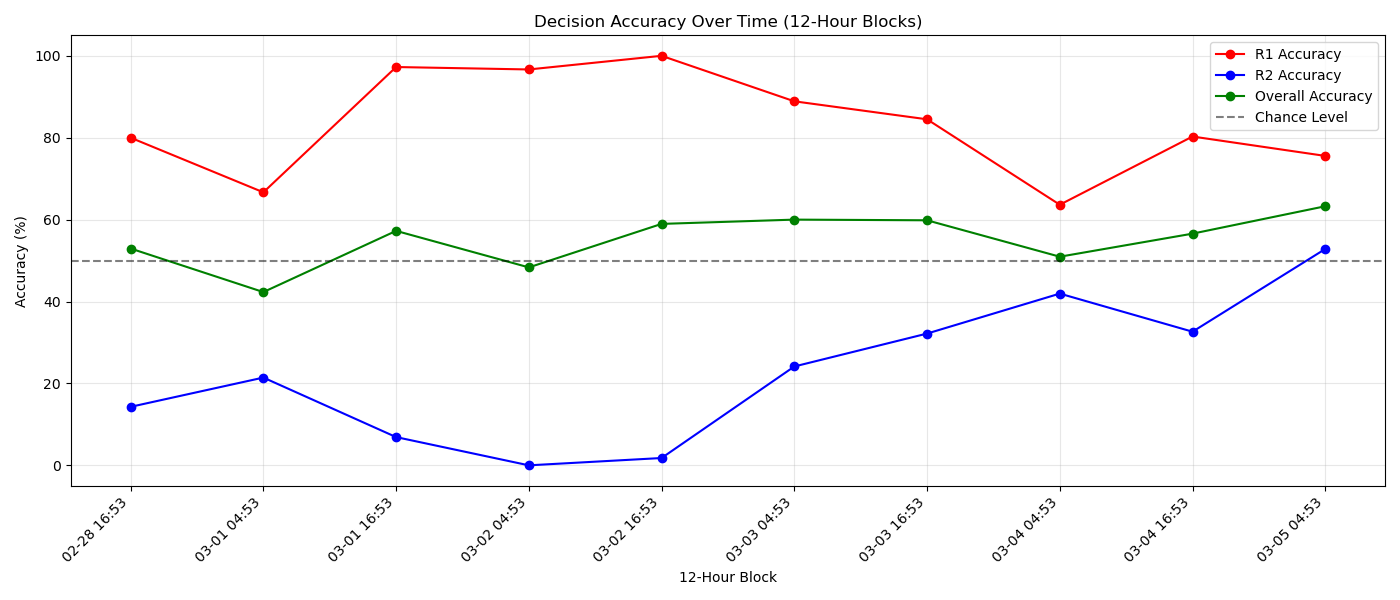

In [16]:
# Determine decision accuracy using 12-hour blocks

def analyze_decision_accuracy(events_df):
    # Make sure the dataframe is sorted by timestamp
    events_df = events_df.sort_values('timestamp')
    
    # Find the start and end times
    start_time = events_df['timestamp'].min()
    end_time = events_df['timestamp'].max()
    
    # Calculate total duration in 12-hour blocks
    total_hours = (end_time - start_time).total_seconds() / 3600
    total_half_days = total_hours / 12
    num_periods = int(np.ceil(total_half_days))
    
    # Initialize results storage
    period_results = []
    
    # Process each 12-hour period
    for period in range(num_periods):
        period_start = start_time + pd.Timedelta(hours=period*12)
        period_end = start_time + pd.Timedelta(hours=(period+1)*12)
        
        # Filter data for this period
        period_data = events_df[(events_df['timestamp'] >= period_start) & 
                               (events_df['timestamp'] < period_end)]
        
        # Skip if no data in this period
        if len(period_data) == 0:
            continue
            
        # Analyze decision accuracy
        r1_correct, r1_total, r2_correct, r2_total = calculate_decision_accuracy(period_data)
        
        # Calculate percentages
        r1_accuracy = (r1_correct / r1_total * 100) if r1_total > 0 else 0
        r2_accuracy = (r2_correct / r2_total * 100) if r2_total > 0 else 0
        overall_accuracy = ((r1_correct + r2_correct) / (r1_total + r2_total) * 100) if (r1_total + r2_total) > 0 else 0
        
        # Store results
        period_results.append({
            'period_start': period_start,
            'period_end': period_end,
            'r1_accuracy': r1_accuracy,
            'r1_correct': r1_correct,
            'r1_total': r1_total,
            'r2_accuracy': r2_accuracy,
            'r2_correct': r2_correct,
            'r2_total': r2_total,
            'overall_accuracy': overall_accuracy
        })
    
    return pd.DataFrame(period_results)

def calculate_decision_accuracy(period_data):
    """
    Calculate decision accuracy:
    - r1_olf_valve followed by r1_poke = correct
    - r2_olf_valve followed by r2_poke = correct
    """
    r1_correct = 0
    r1_total = 0
    r2_correct = 0
    r2_total = 0
    
    # Reset index for easier sequential analysis
    data = period_data.reset_index(drop=True)
    
    # Analyze each row that has an olfactometer valve opening
    for i in range(len(data) - 1):  # -1 to avoid index error when looking ahead
        # Check for r1 valve openings
        if data.loc[i, 'r1_olf_valve']:
            r1_total += 1
            
            # Look ahead for the next poke after this valve opening
            for j in range(i+1, len(data)):
                if data.loc[j, 'r1_poke'] or data.loc[j, 'r2_poke']:
                    # Found a poke, was it the correct one?
                    if data.loc[j, 'r1_poke']:
                        r1_correct += 1
                    break
                    
        # Check for r2 valve openings
        if data.loc[i, 'r2_olf_valve']:
            r2_total += 1
            
            # Look ahead for the next poke after this valve opening
            for j in range(i+1, len(data)):
                if data.loc[j, 'r1_poke'] or data.loc[j, 'r2_poke']:
                    # Found a poke, was it the correct one?
                    if data.loc[j, 'r2_poke']:
                        r2_correct += 1
                    break
    
    return r1_correct, r1_total, r2_correct, r2_total

# Call the analysis function
accuracy_by_period = analyze_decision_accuracy(events_df_adjusted)

# Display results
display(accuracy_by_period)

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(range(len(accuracy_by_period)), accuracy_by_period['r1_accuracy'], 'ro-', label='R1 Accuracy')
plt.plot(range(len(accuracy_by_period)), accuracy_by_period['r2_accuracy'], 'bo-', label='R2 Accuracy')
plt.plot(range(len(accuracy_by_period)), accuracy_by_period['overall_accuracy'], 'go-', label='Overall Accuracy')
plt.axhline(y=50, color='k', linestyle='--', alpha=0.5, label='Chance Level')

plt.xlabel('12-Hour Block')
plt.ylabel('Accuracy (%)')
plt.title('Decision Accuracy Over Time (12-Hour Blocks)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add datetime labels on x-axis (with both date and time)
time_labels = [d.strftime('%m-%d %H:%M') for d in accuracy_by_period['period_start']]
plt.xticks(range(len(accuracy_by_period)), time_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()